<a href="https://colab.research.google.com/github/blueeagle100/stereo_vision_starter/blob/main/kitti_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KITTI Stereo Vision

In this notebook we will explore stereo vision through example by using raw city driving data from the [KITTI](http://www.cvlibs.net/datasets/kitti/raw_data.php) dataset. This tutorial will be extremely high level, but it will lay out the basic steps needed to perform each task. Research can be conducted in an as needed basis to learn more about each of these steps.



A readme for the KITTI data can be found [here](https://github.com/yanii/kitti-pcl/blob/master/KITTI_README.TXT). A paper that details the data collection can be found [here](http://www.cvlibs.net/publications/Geiger2013IJRR.pdf)



We will download the data from the KITTI website and access it in the collab environment. I am using the raw city data (2011_09_26_drive_0106_sync).

This data is synced and rectified. In a future tutorial we will discuss why this is important, for now we will explore the data at a high level.

### ADD SIMPLE EXPLAINATION OF STEREO VISION

For a nice overview of stereo vision please see this [tutorial](https://medium.com/analytics-vidhya/distance-estimation-cf2f2fd709d8)

In [1]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0106/2011_09_26_drive_0106_sync.zip

--2022-08-24 21:39:11--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0106/2011_09_26_drive_0106_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.46.7
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.46.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 936875950 (893M) [application/zip]
Saving to: ‘2011_09_26_drive_0106_sync.zip’

2011_09_26_drive_01 100%[===================>] 893.47M  43.0MB/s    in 22s     

2022-08-24 21:39:33 (41.4 MB/s) - ‘2011_09_26_drive_0106_sync.zip’ saved [936875950/936875950]



And now we will download the corresponding calibration file

In [4]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip

--2022-08-24 21:49:24--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.75.167
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.75.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4068 (4.0K) [application/zip]
Saving to: ‘2011_09_26_calib.zip’

2011_09_26_calib.zi 100%[===================>]   3.97K  --.-KB/s    in 0s      

2022-08-24 21:49:24 (58.5 MB/s) - ‘2011_09_26_calib.zip’ saved [4068/4068]



In [2]:
!jar xf 2011_09_26_drive_0106_sync.zip

In [5]:
!jar xf 2011_09_26_calib.zip

In our data folder we have images from 2 gray stereo cameras and 2 color stereo cameras. We also have LiDAR point clouds and GPS and IMU data. 

We will focus on the data from the 2 color cameras. The folder labeled "image_02" corresponds to the left camera and "image_03" corresponds to the right camera.

#### Base Library Import

In [260]:
import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

### Get data

In [36]:
DATA_PATH = r'2011_09_26/2011_09_26_drive_0106_sync'

left_image_paths = glob(os.path.join(DATA_PATH, 'image_02/data/*.png'))
right_image_paths = glob(os.path.join(DATA_PATH, 'image_03/data/*.png'))

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")

Number of left images: 227
Number of right images: 227


### Visualize the data

In [54]:
index = 10

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
right_image = cv2.cvtColor(cv2.imread(right_image_paths[index]), cv2.COLOR_BGR2RGB)

print(f"The shape of an image is: {left_image.shape}")

The shape of an image is: (375, 1242, 3)


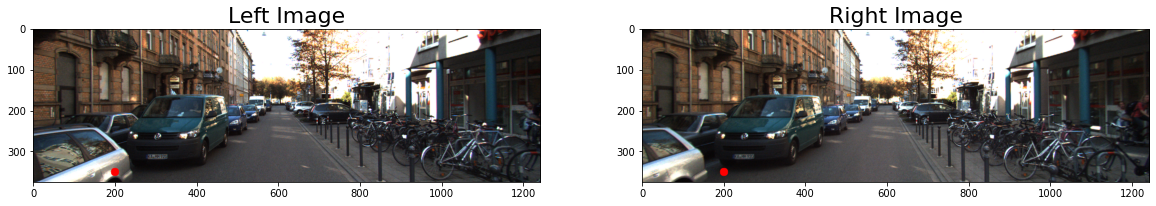

In [55]:
# draw a point of interest 
location = (200, 350)

cv2.circle(left_image, location, 10, [255, 0, 0], -1)
cv2.circle(right_image, location, 10, [255, 0, 0], -1)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(left_image)
ax1.set_title('Left Image', size=22)
ax2.imshow(right_image)
ax2.set_title('Right Image', size=22);

Both images look very similar but there are subtle differences.

In the left image at the location (200, 350) we see a point on the silver car just above the wheel well. If we look at this same location in the right image, we only see paved road. We can see that the same corresponding point of the silver car is actually shifted to the left by several pixels. 

This difference in object location between the left and right images is known as the disparity. Disparity is inversly proportional to depth and is sometimes misnomered as depth. We can use disparity (along with a few other things) to compute object depth in stereo vision!

Now let's take a look at another point further away

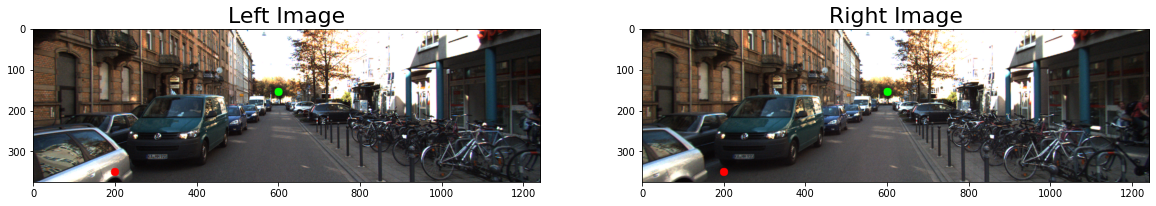

In [56]:
# draw a point of interest 
location_2 = (600, 155)

cv2.circle(left_image, location_2, 10, [0, 255, 0], -1)
cv2.circle(right_image, location_2, 10, [0, 255, 0], -1)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(left_image)
ax1.set_title('Left Image', size=22)
ax2.imshow(right_image)
ax2.set_title('Right Image', size=22);

In this case the location of interest in both images is far away from the camera. In both images the point practically corresponds to the same location (right at the tree trunk). This illustrates that fact that disparity is less intense as you go further in depth. (i.e. disparity is inversely proportional to depth). 

You can actually visualize disparity yourself by holding an object in front of your face and quickly switch opening/closing our left and right eyes. You will see that the object jumps to the left and right as you hold it close, but as you extend it you will see less and less of a jump. Go ahead, try it!


Another thing to keep in mind is that the error of stereo depth estimation grows quadratically with depth [1](https://arxiv.org/pdf/1812.07179.pdf). We will put this statement to the test later using the LiDAR point clouds as the true depth of our objects.

### Now let's compute a disparity map for the entire image!

We will now compute the disparity using opencv. The alogirthm we are using is called Stereo SGBM (Semi Global Matching). You can read more about the theory [here](https://core.ac.uk/download/pdf/11134866.pdf). The opencv documentation is located [here](https://docs.opencv.org/3.4/d1/d9f/classcv_1_1stereo_1_1StereoBinarySGBM.html)

In [106]:
def compute_sgbm_disparity(left_image, right_image, num_disparities=5*16, 
                           block_size=11, window_size=5, display=False):
    """ Computes the disparity of an image pair using the SGBM algoithm.
        Inputs: 
            image_left/_right - (MxN) grayscale input images
            see opencv documentation for "StereoBM_create"
        Outputs:
            disparity (MxN) computed disparity map for the input images
        
        NOTE: image_left must be the left image (same for the right) or 
              unexpected results will occur due to 
    """
    # P1 and P2 control disparity smoothness (recommended values below)
    P1 = 8 * 3 * window_size**2
    P2 = 32 * 3 * window_size**2
    sgbm_obj = cv2.StereoSGBM_create(0, num_disparities, block_size, 
        P1, P2, mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)
        
    # compute disparity
    disparity = sgbm_obj.compute(left_image, right_image).astype(np.float32)/16.0

    # display is desired
    if display:
      plt.figure(figsize = (40,20))
      plt.imshow(disparity, cmap='cividis')
      plt.title('Disparity Map', size=25)
      plt.show();

    return disparity

In [107]:
left_image_gray = cv2.cvtColor(left_image, cv2.COLOR_RGB2GRAY)
right_image_gray = cv2.cvtColor(right_image, cv2.COLOR_RGB2GRAY)

##### Now we will use an interactive display to help tune our disparity parameters

In [108]:
from IPython.display import Image
from ipywidgets import interact, interactive, fixed

disparity = interactive(compute_sgbm_disparity, 
                        left_image=fixed(left_image_gray), 
                        right_image=fixed(right_image_gray), 
                        num_disparities=(0,512,16), 
                        block_size=(1,19,2), 
                        window_size=(1,13,2),
                        display=fixed(True))
display(disparity)

interactive(children=(IntSlider(value=80, description='num_disparities', max=512, step=16), IntSlider(value=11…

After playing with the parameters we can take note of the combination that gives us the best results.

In [109]:
num_disparities = disparity.kwargs['num_disparities']
block_size = disparity.kwargs['block_size']
window_size = disparity.kwargs['window_size']

### Now let's compute the depth map

Now we are ready to compute the depth map, but we will first need to get a few things.
 - We will need to get the 3x4 rectified projection matrix from our calibration data
 - We will need to mathematically work out how to compute the depth from disparity

In [356]:
calib_df = pd.read_csv('2011_09_26/calib_cam_to_cam.txt', skiprows=2, header=None, sep=':').T
calib_df.columns = calib_df.iloc[0, :]
calib_df.drop(index=0, inplace=True)
calib_df

0                        S_00  \
1   1.392000e+03 5.120000e+02   

0                                               K_00  \
1   9.842439e+02 0.000000e+00 6.900000e+02 0.0000...   

0                                               D_00  \
1   -3.728755e-01 2.037299e-01 2.219027e-03 1.383...   

0                                               R_00  \
1   1.000000e+00 0.000000e+00 0.000000e+00 0.0000...   

0                                      T_00  ...  \
1   2.573699e-16 -1.059758e-16 1.614870e-16  ...   

0                                               R_03  \
1   9.995599e-01 1.699522e-02 -2.431313e-02 -1.70...   

0                                       T_03                   S_rect_03  \
1   -4.731050e-01 5.551470e-03 -5.250882e-03   1.242000e+03 3.750000e+02   

0                                          R_rect_03  \
1   9.998321e-01 -7.193136e-03 1.685599e-02 7.232...   

0                                          P_rect_03  
1   7.215377e+02 0.000000e+00 6.095593e+02 -3.395...  

[1 rows x 32 columns]

In [157]:
p_cols = [col for col in calib_df.columns if 'p' in col.lower()]
p_cols

['P_rect_00', 'P_rect_01', 'P_rect_02', 'P_rect_03']

In [179]:
get_p_mat = lambda x : np.array(list(x)[0].strip().split(' ')).astype(np.float32).reshape((3, 4))

p_left = get_p_mat(calib_df['P_rect_02'])
p_right = get_p_mat(calib_df['P_rect_03'])

print('left projection matrix')
print(p_left)

print()
print('right projection matrix')
print(p_right)

left projection matrix
[[7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01]
 [0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01]
 [0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03]]

right projection matrix
[[ 7.215377e+02  0.000000e+00  6.095593e+02 -3.395242e+02]
 [ 0.000000e+00  7.215377e+02  1.728540e+02  2.199936e+00]
 [ 0.000000e+00  0.000000e+00  1.000000e+00  2.729905e-03]]


For the the left and right images, we will need to decompose the camera projection matrix into:
 - The Intrinsic Calibration Matrix (K) 
 - The rotation Matrix (R)
 - The translation Matrix (T)

 See these [slides](https://www.cs.cmu.edu/~16385/s17/Slides/11.1_Camera_matrix.pdf) for more details.

Also take a look at this [video tutorial](https://www.youtube.com/watch?v=S-UHiFsn-GI&list=PL2zRqk16wsdoCCLpou-dGo7QQNks1Ppzo&index=1)

In [111]:
def decompose_projection_matrix(p):    
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = t/t[3]

    return k, r, t

Now the formula to compute the depth map will be displayed. More insight will be provided in a future tutorial for now we just want to explore from a high level.

<br>
<br>

z = depth 
<br>
d = disparity 
<br>
b = baseline &#8594; camera separation on the X-axis (assume cameras are aligned on the Y-axis)
<br>
f = focal length of the cameras &#8594; assume equal focal length for each camera

<br>
<br>

$$ z = \frac{f \cdot b}{d} $$

In [112]:
def calc_depth_map(disp_left, k_left, t_left, t_right):
    # Get the focal length from the K matrix
    f = k_left[0, 0]
    
    # Get the distance between the cameras from the t matrices (baseline)
    b = np.abs(t_left[0] - t_right[0])[0]
    
    # Replace all instances of 0 and -1 disparity with a small minimum value (to avoid div by 0 or negatives)
    disp_left[disp_left <= 0] = 0.1
    
    # Calculate the depths 
    depth_map = f*b / disp_left 

    return depth_map

In [188]:
# decompose the projection matrices

k_left, r_left, t_left = decompose_projection_matrix(p_left)
k_right, r_right, t_right = decompose_projection_matrix(p_right)

### Now let's compute the depth map!

In [189]:
depth_map = calc_depth_map(disparity, k_left, t_left, t_right)

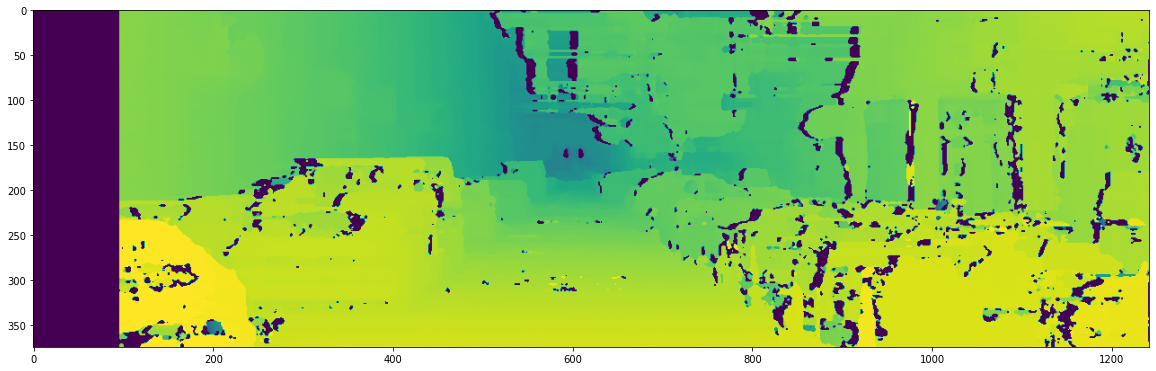

In [240]:
# we need to take the log of the depth map in order to properly visualize it
fig = plt.figure(figsize=(20, 10))
plt.imshow(np.log(depth_map), cmap='viridis_r'); # or 'cividis_r'

Here we can visualize the depth map. Click on the image to zoom in. The differences between object distances are very subtil and become less defined as we go further back.

### Time for Object detection

Now let's run an object detector on our image and see how far away each object is. We will use YOLOv5 to get the job done. For more information on YOLO or object detection in general I invite you to go through this excellent series of [blog posts](https://pyimagesearch.com/2022/04/04/introduction-to-the-yolo-family/).

In [252]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 12005, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 12005 (delta 3), reused 0 (delta 0), pack-reused 11996
Receiving objects: 100% (12005/12005), 12.44 MiB | 22.15 MiB/s, done.
Resolving deltas: 100% (8253/8253), done.


In [ ]:
!pip install -r yolov5/requirements.txt  #Install whatever is needed

In [254]:
import torch

# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-8-25 Python-3.7.13 torch-1.12.1+cu113 CPU



  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


#### Reload images and detect objects

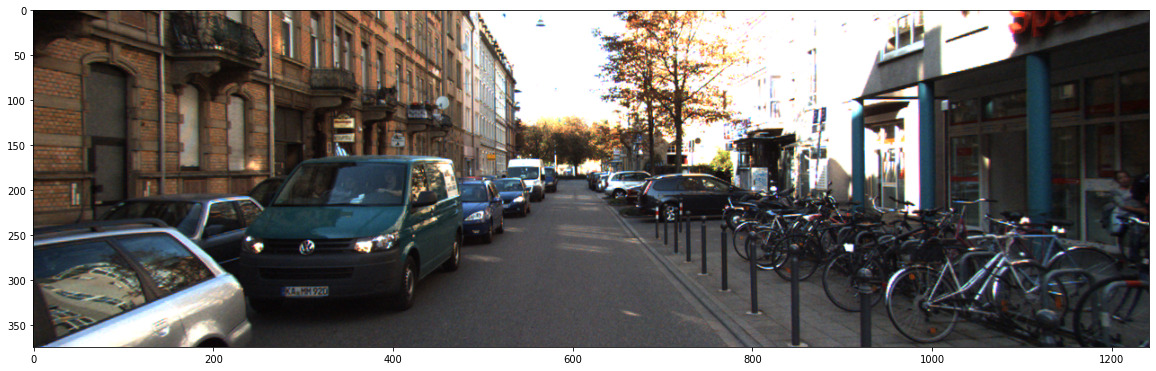

In [354]:
left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
plt.imshow(left_image);

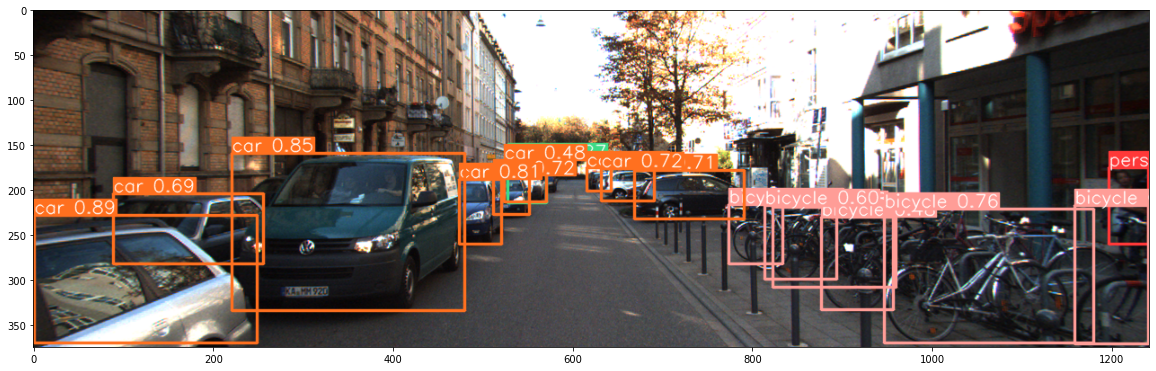

In [355]:
detections = model(left_image)

detections.show() # draw boxes on image
plt.imshow(left_image);

Now we want to find the depth of each detected object. To do this we will follow these steps

In [336]:
# draw boxes on image
boxed_image = left_image.copy()

# get bounding box locations (x1,y1), (x2,y2) Prob, class
bboxes = detections.xyxy[0]
for bbox in bboxes:
    pt1 = torch.round(bbox[0:2]).to(torch.int).numpy()
    pt2 = torch.round(bbox[2:4]).to(torch.int).numpy()
    prob = bbox[4]
    category = bbox[5]
    color = get_color(category.numpy())

    cv2.rectangle(boxed_image, pt1, pt2, color, 1)

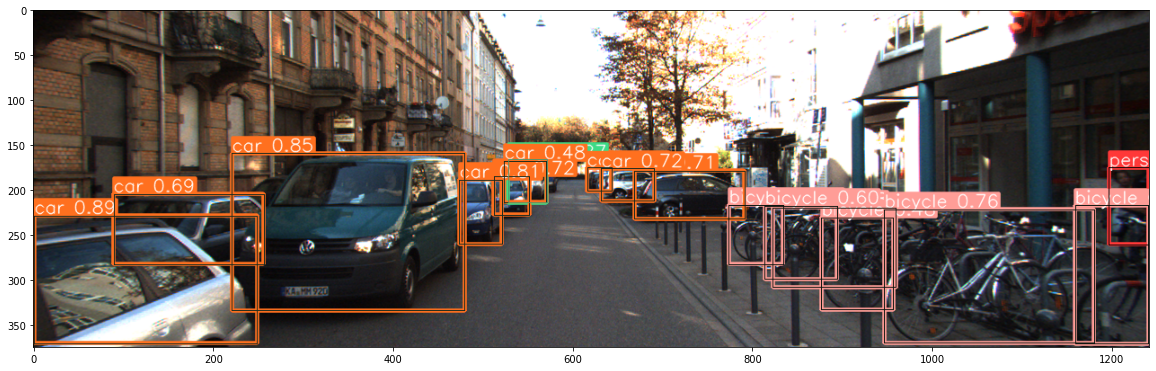

In [337]:
plt.imshow(boxed_image);

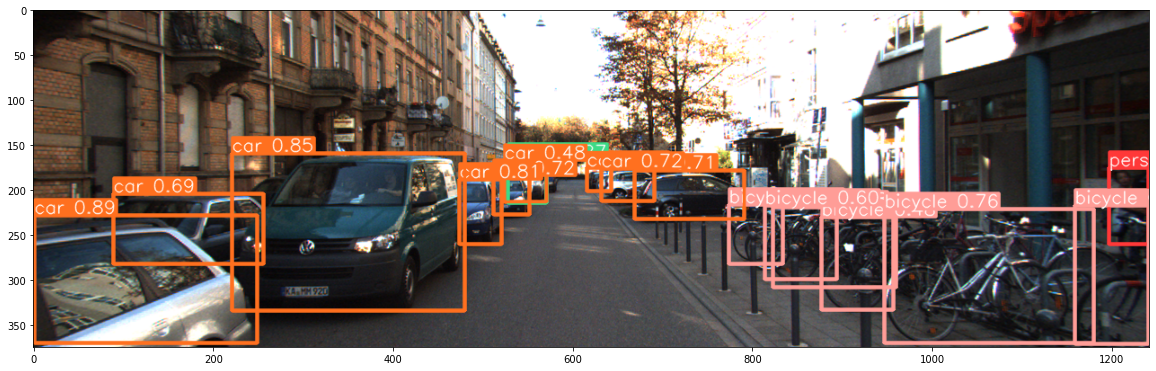

In [338]:
plt.imshow(left_image)

In [325]:
torch.round(bbox[0:2]).to(torch.int).numpy()

array([  1, 229], dtype=int32)

In [332]:
category.numpy()

array(          2, dtype=float32)

In [327]:
color

[tensor(24.), tensor(42.), tensor(126.)]

In [293]:
detections.names

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou